In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub

# Download latest version
path = kagglehub.dataset_download("gpiosenka/70-dog-breedsimage-data-set")

print("Path to dataset files:", path)
dog_df = pd.read_csv(path + '/dogs.csv')

100%|██████████| 215M/215M [00:11<00:00, 19.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2


In [4]:
# libraries for preprocessing
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [5]:
image_path = path + '/' + dog_df['filepaths'].iloc[0]

print(image_path)

/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train/Afghan/001.jpg


In [6]:
# get dataframes of dogs by train/test/validation

train_df = dog_df[dog_df.iloc[:, 2] == "train"].copy()
valid_df = dog_df[dog_df.iloc[:, 2] == "valid"].copy()
test_df = dog_df[dog_df.iloc[:, 2] == "test"].copy()
train_df.head()

# get folder paths of dogs by train/test/validation

train_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/train'
valid_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/valid'
test_path = '/root/.cache/kagglehub/datasets/gpiosenka/70-dog-breedsimage-data-set/versions/2/test'

Below is preprocessing + resnet50 model attempt

In [7]:
# considered grayscale but read online somewhere that color is helpful for breed identification
# preprocessing tasks

train_datagen = ImageDataGenerator(
    rescale=1./255,             # Normalize pixel values to [0, 1]
    shear_range=0.2,            # Apply shear transformations
    zoom_range=0.2,             # Apply zoom transformations
    horizontal_flip=True       # Flip images horizontally
)

test_datagen = ImageDataGenerator(rescale=1./255)  # Only rescale for test/validation

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),    # Resize images
    batch_size=32,             # Adjust as needed based on your memory
    class_mode='categorical'   # Use 'binary' if you have only two classes
)

validation_generator = test_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7946 images belonging to 70 classes.
Found 700 images belonging to 70 classes.
Found 700 images belonging to 70 classes.


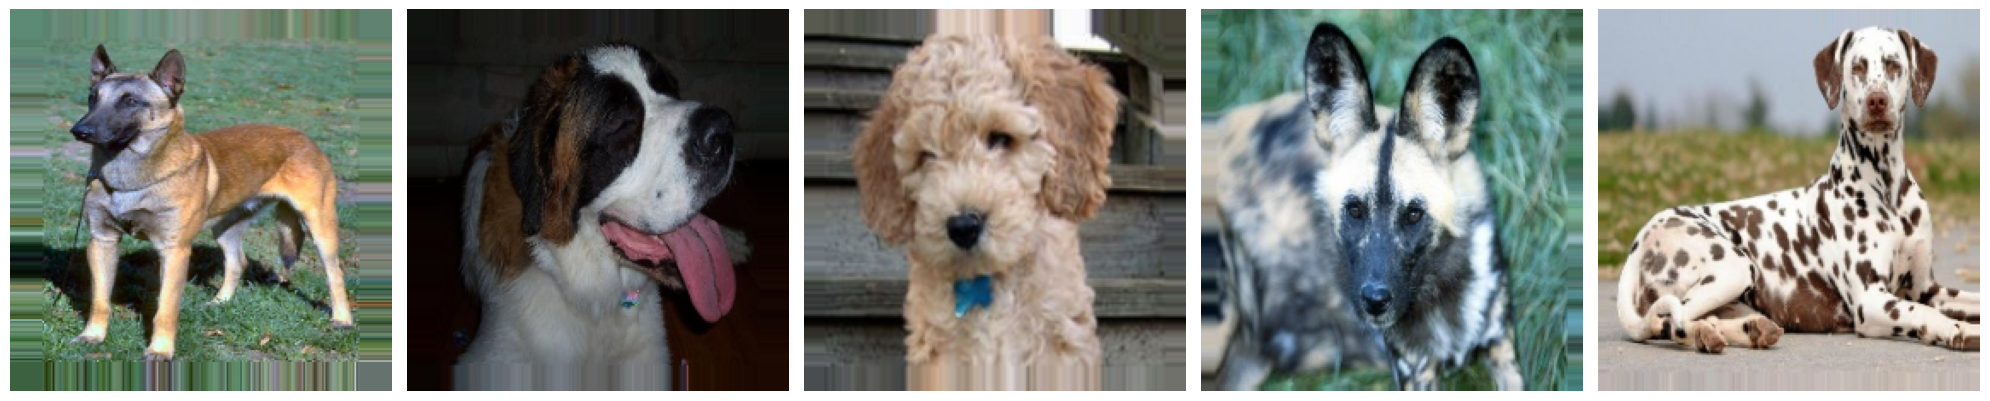

In [6]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20, 20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


sample_training_images, _ = next(train_generator)
plot_images(sample_training_images[:5])

In [2]:
from tensorflow.keras.applications import ResNet50  # Or MobileNetV2, EfficientNetB0, etc.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

In [7]:
# Load model
base_model = ResNet50(weights='imagenet', include_top=False)

# Classifier
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(70, activation='softmax'))  # 70 to match our earlier shape

# Compile
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model.fit(train_generator,epochs=50, validation_data=validation_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 180s 467ms/step - accuracy: 0.2349 - loss: 3.1901 - val_accuracy: 0.0143 - val_loss: 4.6060
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 84s 326ms/step - accuracy: 0.6046 - loss: 1.3372 - val_accuracy: 0.0100 - val_loss: 5.9790
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 325ms/step - accuracy: 0.7080 - loss: 0.9817 - val_accuracy: 0.1514 - val_loss: 4.4179
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 324ms/step - accuracy: 0.7717 - loss: 0.7304 - val_accuracy: 0.4657 - val_loss: 2.2747
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 322ms/step - accuracy: 0.8137 - loss: 0.5814 - val_accuracy: 0.6300 - val_loss: 1.5997
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 322ms/step - accuracy: 0.8535 - loss: 0.4630 - val_accuracy: 0.7700 - val_loss: 1.1715
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 321ms/step - accuracy: 0.8625 - loss: 0.4137 - val_accuracy: 0.6271 - val_loss: 1.7485
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 83s 325ms/step - accuracy: 0.8854 - loss: 0.3605 - va

Above attempt went really well!. Attempting resnet50 model again with adjustments just out of curiosity



In [8]:
# making adjustments to Learning Rate, Freezing Layers, optimizers
from tensorflow.keras.optimizers import SGD # different optimizer

# same as before
base_model_adjusted = ResNet50(weights='imagenet', include_top=False)
model_adjusted = Sequential()
model_adjusted.add(base_model_adjusted)
model_adjusted.add(GlobalAveragePooling2D())
model_adjusted.add(Dense(70, activation='softmax'))

# Freeze layers - https://stackoverflow.com/questions/46610732/how-to-freeze-some-layers-when-fine-tune-resnet50
# https://www.linkedin.com/advice/0/how-can-you-determine-which-layers-freeze-when-okd8f#:~:text=1.-,Why%20Freeze%20Layers%3F,a%20similar%20structure%20or%20content.
for layer in base_model_adjusted.layers:
    layer.trainable = False
model_adjusted.save_weights("all_nontrainable.weights.h5")

base_model_adjusted = ResNet50(weights='imagenet', include_top=False)
model_adjusted = Sequential()
model_adjusted.add(base_model_adjusted)
model_adjusted.add(GlobalAveragePooling2D())
model_adjusted.add(Dense(70, activation='softmax'))

for layer in base_model_adjusted.layers[:-26]:
    layer.trainable = False
model_adjusted.load_weights("all_nontrainable.weights.h5")

# Compile
model_adjusted.compile(optimizer=SGD(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train
model_adjusted.fit(train_generator,epochs=50, validation_data=validation_generator)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


249/249 ━━━━━━━━━━━━━━━━━━━━ 116s 383ms/step - accuracy: 0.0322 - loss: 4.2401 - val_accuracy: 0.0443 - val_loss: 4.1609
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.0806 - loss: 4.0027 - val_accuracy: 0.0629 - val_loss: 3.9434
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 320ms/step - accuracy: 0.0946 - loss: 3.8952 - val_accuracy: 0.0914 - val_loss: 3.8309
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 81s 318ms/step - accuracy: 0.1138 - loss: 3.7971 - val_accuracy: 0.1143 - val_loss: 3.7368
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 81s 318ms/step - accuracy: 0.1273 - loss: 3.6998 - val_accuracy: 0.1243 - val_loss: 3.6601
Epoch 6/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 320ms/step - accuracy: 0.1507 - loss: 3.6144 - val_accuracy: 0.1386 - val_loss: 3.5588
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.1572 - loss: 3.5296 - val_accuracy: 0.1386 - val_loss: 3.4559
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 82s 319ms/step - accuracy: 0.1696 - loss: 3.4449 - va

CNN architecture


In [ ]:
!pip install tensorflow.keras.layers
!pip install tensorflow.keras.optimizers
!pip install keras.models
!pip install keras.layers
!pip install keras.utils
!pip install keras.preprocessing.image

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout , Input , BatchNormalization
from tensorflow.keras.optimizers import RMSprop, Adam

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# rescale, create directory paths
datagen = ImageDataGenerator(rescale=1./255,)

train_dir = path + '/train/'
test_dir = path + '/test/'
val_dir = path + '/valid/'

In [ ]:
train_dataset = datagen.flow_from_directory(
    train_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)

# Load testing data
test_dataset = datagen.flow_from_directory(
    test_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)
val_dataset = datagen.flow_from_directory(
    val_dir,
    batch_size=64,
    target_size=(224,224),
    class_mode='categorical'
)
num_classes = 70

In [ ]:
input_shape = (224, 224, 3)

model = Sequential()
model.add(Input(shape=input_shape))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(70, activation='softmax'))

model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=50, validation_data=val_dataset , batch_size=32 , verbose=1)
